In [1]:
import random
import torch
import pydicom
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import cv2
from models.fpn import retinanet
from dataGen.data_loader import load_dicom
from utils import visualize

In [2]:
random.seed(42)

In [3]:
! tree checkpoints/

checkpoints/
└── se_resnext50_32x4d
    └── fold_1
        ├── best.pth.tar
        ├── config.json
        ├── epoch10.pth.tar
        ├── epoch11.pth.tar
        ├── epoch12.pth.tar
        ├── epoch13.pth.tar
        ├── epoch14.pth.tar
        ├── epoch15.pth.tar
        ├── epoch1.pth.tar
        ├── epoch2.pth.tar
        ├── epoch3.pth.tar
        ├── epoch4.pth.tar
        ├── epoch5.pth.tar
        ├── epoch6.pth.tar
        ├── epoch7.pth.tar
        ├── epoch8.pth.tar
        ├── epoch9.pth.tar
        └── train.log

2 directories, 18 files


In [4]:
state_dict = torch.load('checkpoints/se_resnext50_32x4d/fold_1/epoch15.pth.tar')
state_dict.keys()

dict_keys(['epoch', 'state_dict', 'optim_dict', 'best_val_loss'])

In [5]:
model = retinanet(pretrained_imagenet=False)

In [6]:
model.load_state_dict(state_dict=state_dict['state_dict'])

In [7]:
with open('fold_data/valfps_1.pkl', 'rb') as f:
    valfps = pickle.load(f)
with open('fold_data/valbox_1.pkl', 'rb') as f:
    valbox = pickle.load(f)

In [8]:
imgid = random.sample(valfps, 1)[0]
imgid

'2dac040f-71c3-4bd3-8d4f-4320066e2d04'

In [9]:
imgid = '06893030-14ab-456d-a22d-05070773e370'
valbox[imgid]

[[634, 314, 853, 622], [266, 310, 486, 599]]

In [10]:
gt_bboxes = (np.array(valbox[imgid])/2).astype(int).tolist()
gt_bboxes

[[317, 157, 426, 311], [133, 155, 243, 299]]

In [11]:
gt_labels = [1]*len(gt_bboxes)
gt_labels

[1, 1]

In [12]:
img = load_dicom(imgid)

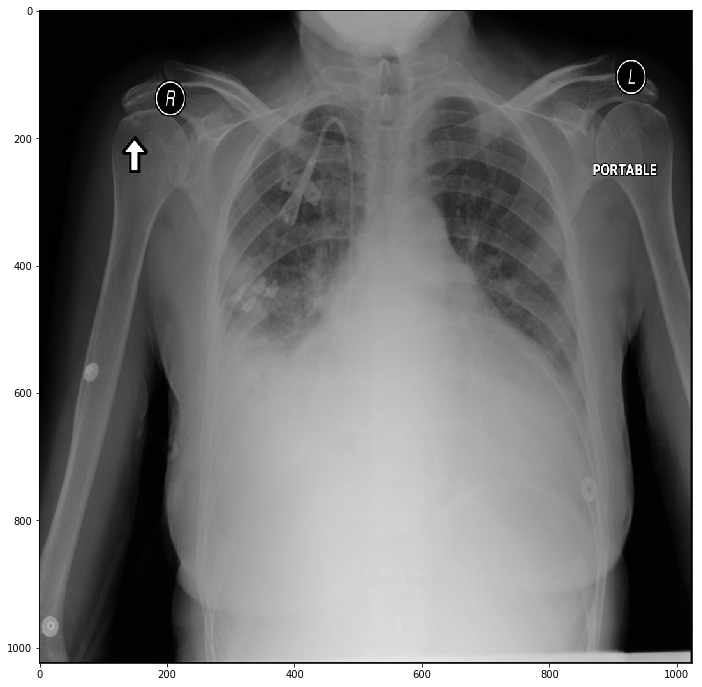

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img)

In [14]:
def process_image(img, image_shape=(512, 512), rsna_mean=0.49, rsna_std=0.23):
    img_resized = cv2.resize(img, image_shape, interpolation=cv2.INTER_LINEAR)
    img_resized = img_resized.astype(np.float32) / 255.0
    img_norm = (img_resized - rsna_mean) / rsna_std
    img_norm = np.transpose(img_norm, (2, 0, 1))
    img_norm = np.expand_dims(img_norm, 0)
    assert img_norm.shape == (1, 3, *image_shape)
    return img_resized, img_norm

In [15]:
img_resized, img_norm = process_image(img)

In [16]:
model = model.cuda()
model.eval()

retinanet(
  (bottom_up): BackBone(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu):

In [17]:
with torch.no_grad():
    results = model.predict(torch.tensor(img_norm, dtype=torch.float32, device='cuda'))[0]

0.5793070197105408


In [18]:
# tolist
for k, v in results.items():
    results[k] = v.tolist()
results

{'bboxes': [[310, 184, 432, 391]],
 'scores': [0.5793070197105408],
 'category_id': [0]}

In [19]:
results['scores']

[0.5793070197105408]

In [20]:
(np.array([179, 643, 458, 798])/2).astype(int)

array([ 89, 321, 229, 399])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


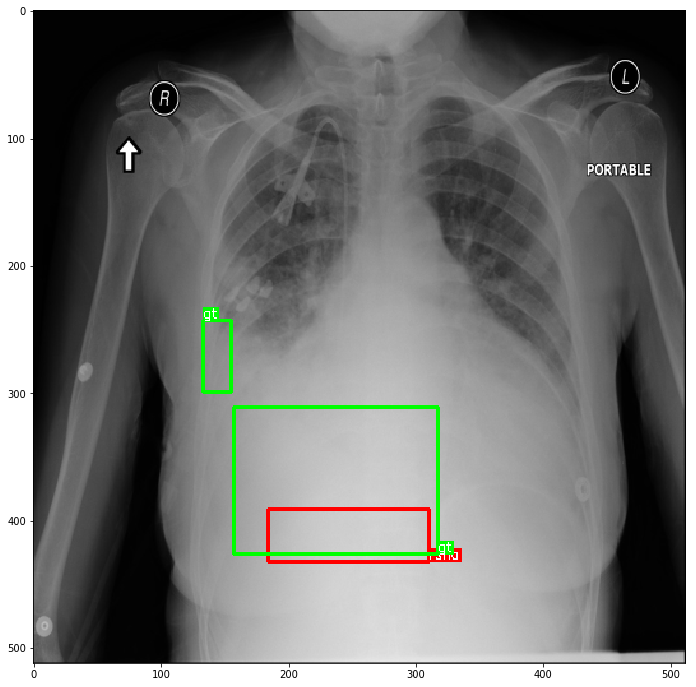

In [21]:
visualize({'image': img_resized, 'bboxes':results['bboxes'] + gt_bboxes, 'category_id':results['category_id']+gt_labels},
     category_id_to_name={0:'rsna', 1:'gt'})